In [83]:
from __future__ import print_function
from collections import OrderedDict

import torch
import torch.nn as nn
from torch.nn import init
from torch.autograd import Variable
from torch import autograd

import time
import _pickle as cPickle

import urllib
import matplotlib.pyplot as plt
plt.rcParams['figure.dpi'] = 80
# plt.style.use('seaborn-pastel')

import os
import sys
import codecs
import re
import numpy as np

In [84]:
#parameters for the Model
parameters = OrderedDict()
parameters['train'] = "/kaggle/input/hichic/train.txt" #Path to train file
parameters['dev'] = "/kaggle/input/hichic/test.txt" #Path to test file
# parameters['test'] = "./data/eng.testb" #Path to dev file
parameters['tag_scheme'] = "BIO" #BIO or BIOES
parameters['lower'] = True # Boolean variable to control lowercasing of words
parameters['zeros'] =  True # Boolean variable to control replacement of  all digits by 0 
parameters['char_dim'] = 30 #Char embedding dimension
parameters['word_dim'] = 100 #Token embedding dimension
parameters['word_lstm_dim'] = 200 #Token LSTM hidden layer size
parameters['word_bidirect'] = True #Use a bidirectional LSTM for words
parameters['embedding_path'] = "/kaggle/input/glove6b100dtxt/glove.6B.100d.txt" #Location of pretrained embeddings
parameters['all_emb'] = 1 #Load all embeddings
parameters['crf'] =1 #Use CRF (0 to disable)
parameters['dropout'] = 0.5 #Droupout on the input (0 = no dropout)
parameters['epoch'] =  50 #Number of epochs to run"
parameters['weights'] = "" #path to Pretrained for from a previous run
parameters['name'] = "self-trained-model" # Model name
parameters['gradient_clip']=5.0
parameters['char_mode']="CNN"
models_path = "./models/" #path to saved models

#GPU
parameters['use_gpu'] = torch.cuda.is_available() #GPU Check
use_gpu = parameters['use_gpu']

parameters['reload'] = None #"./models/pre-trained-model" 

#Constants
START_TAG = '<START>'
STOP_TAG = '<STOP>'

In [85]:
#paths to files 
#To stored mapping file
mapping_file = 'mapping.pkl'

#To stored model
name = parameters['name']
model_name = models_path + name #get_name(parameters)

if not os.path.exists(models_path):
    os.makedirs(models_path)

In [86]:
def zero_digits(s):
    """
    Replace every digit in a string by a zero.
    """
    return re.sub('\d', '0', s)

def load_sentences(path, zeros):
    """
    Load sentences. A line must contain at least a word and its tag.
    Sentences are separated by empty lines.
    """
    sentences = []
    sentence = []
    for line in codecs.open(path, 'r', 'utf8'):
        line = zero_digits(line.rstrip()) if zeros else line.rstrip()
        if not line:
            if len(sentence) > 0:
                if 'DOCSTART' not in sentence[0][0]:
                    sentences.append(sentence)
                sentence = []
        else:
            word = line.split()
            assert len(word) >= 2
            sentence.append(word)
    if len(sentence) > 0:
        if 'DOCSTART' not in sentence[0][0]:
            sentences.append(sentence)
    return sentences

In [87]:
train_sentences = load_sentences(parameters['train'], parameters['zeros'])
# test_sentences = load_sentences(parameters['test'], parameters['zeros'])
dev_sentences = load_sentences(parameters['dev'], parameters['zeros'])

In [88]:
def iob2(tags):
    """
    Check that tags have a valid BIO format.
    Tags in BIO1 format are converted to BIO2.
    """
    for i, tag in enumerate(tags):
        if tag == 'O':
            continue
        split = tag.split('-')
        if len(split) != 2 or split[0] not in ['I', 'B']:
            return False
        if split[0] == 'B':
            continue
        elif i == 0 or tags[i - 1] == 'O':  # conversion IOB1 to IOB2
            tags[i] = 'B' + tag[1:]
        elif tags[i - 1][1:] == tag[1:]:
            continue
        else:  # conversion IOB1 to IOB2
            tags[i] = 'B' + tag[1:]
    return True

def iob_iobes(tags):
    """
    the function is used to convert
    BIO -> BIOES tagging
    """
    new_tags = []
    for i, tag in enumerate(tags):
        if tag == 'O':
            new_tags.append(tag)
        elif tag.split('-')[0] == 'B':
            if i + 1 != len(tags) and \
               tags[i + 1].split('-')[0] == 'I':
                new_tags.append(tag)
            else:
                new_tags.append(tag.replace('B-', 'S-'))
        elif tag.split('-')[0] == 'I':
            if i + 1 < len(tags) and \
                    tags[i + 1].split('-')[0] == 'I':
                new_tags.append(tag)
            else:
                new_tags.append(tag.replace('I-', 'E-'))
        else:
            raise Exception('Invalid IOB format!')
    return new_tags

def update_tag_scheme(sentences, tag_scheme):
    """
    Check and update sentences tagging scheme to BIO2
    Only BIO1 and BIO2 schemes are accepted for input data.
    """
    for i, s in enumerate(sentences):
        tags = [w[-1] for w in s]
        # Check that tags are given in the BIO format
        if not iob2(tags):
            s_str = '\n'.join(' '.join(w) for w in s)
            raise Exception('Sentences should be given in BIO format! ' +
                            'Please check sentence %i:\n%s' % (i, s_str))
        if tag_scheme == 'BIOES':
            new_tags = iob_iobes(tags)
            for word, new_tag in zip(s, new_tags):
                word[-1] = new_tag
        else:
            raise Exception('Wrong tagging scheme!')

In [89]:
# update_tag_scheme(train_sentences, parameters['tag_scheme'])
# update_tag_scheme(dev_sentences, parameters['tag_scheme'])
# # update_tag_scheme(test_sentences, parameters['tag_scheme'])

In [90]:
def create_dico(item_list):
    """
    Create a dictionary of items from a list of list of items.
    """
    assert type(item_list) is list
    dico = {}
    for items in item_list:
        for item in items:
            if item not in dico:
                dico[item] = 1
            else:
                dico[item] += 1
    return dico

def create_mapping(dico):
    """
    Create a mapping (item to ID / ID to item) from a dictionary.
    Items are ordered by decreasing frequency.
    """
    sorted_items = sorted(dico.items(), key=lambda x: (-x[1], x[0]))
    id_to_item = {i: v[0] for i, v in enumerate(sorted_items)}
    item_to_id = {v: k for k, v in id_to_item.items()}
    return item_to_id, id_to_item

def word_mapping(sentences, lower):
    """
    Create a dictionary and a mapping of words, sorted by frequency.
    """
    words = [[x[0].lower() if lower else x[0] for x in s] for s in sentences]
    dico = create_dico(words)
    dico['<UNK>'] = 10000000 #UNK tag for unknown words
    word_to_id, id_to_word = create_mapping(dico)
    print("Found %i unique words (%i in total)" % (
        len(dico), sum(len(x) for x in words)
    ))
    return dico, word_to_id, id_to_word

def char_mapping(sentences):
    """
    Create a dictionary and mapping of characters, sorted by frequency.
    """
    chars = ["".join([w[0] for w in s]) for s in sentences]
    dico = create_dico(chars)
    char_to_id, id_to_char = create_mapping(dico)
    print("Found %i unique characters" % len(dico))
    return dico, char_to_id, id_to_char

def tag_mapping(sentences):
    """
    Create a dictionary and a mapping of tags, sorted by frequency.
    """
    tags = [[word[-1] for word in s] for s in sentences]
    dico = create_dico(tags)
    dico[START_TAG] = -1
    dico[STOP_TAG] = -2
    tag_to_id, id_to_tag = create_mapping(dico)
    print("Found %i unique named entity tags" % len(dico))
    return dico, tag_to_id, id_to_tag

In [91]:
dico_words,word_to_id,id_to_word = word_mapping(train_sentences, parameters['lower'])
dico_chars, char_to_id, id_to_char = char_mapping(train_sentences)
dico_tags, tag_to_id, id_to_tag = tag_mapping(train_sentences)

Found 8730 unique words (188887 in total)
Found 109 unique characters
Found 84 unique named entity tags


In [92]:
def lower_case(x,lower=False):
    if lower:
        return x.lower()  
    else:
        return x

In [93]:
def prepare_dataset(sentences, word_to_id, char_to_id, tag_to_id, lower=False):
    """
    Prepare the dataset. Return a list of lists of dictionaries containing:
        - word indexes
        - word char indexes
        - tag indexes
    """
    data = []
    for s in sentences:
        str_words = [w[0] for w in s]
        words = [word_to_id[lower_case(w,lower) if lower_case(w,lower) in word_to_id else '<UNK>']
                 for w in str_words]
        # Skip characters that are not in the training set
        chars = [[char_to_id[c] for c in w if c in char_to_id]
                 for w in str_words]
        tags = [tag_to_id[w[-1]] for w in s]
        data.append({
            'str_words': str_words,
            'words': words,
            'chars': chars,
            'tags': tags,
        })
    return data

train_data = prepare_dataset(
    train_sentences, word_to_id, char_to_id, tag_to_id, parameters['lower']
)
dev_data = prepare_dataset(
    dev_sentences, word_to_id, char_to_id, tag_to_id, parameters['lower']
)
# test_data = prepare_dataset(
#     test_sentences, word_to_id, char_to_id, tag_to_id, parameters['lower']
# )
print("{} / {} sentences in train / dev.".format(len(train_data), len(dev_data))) #len(test_data)

7896 / 788 sentences in train / dev.


In [94]:
all_word_embeds = {}
for i, line in enumerate(codecs.open(parameters['embedding_path'], 'r', 'utf-8')):
    s = line.strip().split()
    if len(s) == parameters['word_dim'] + 1:
        all_word_embeds[s[0]] = np.array([float(i) for i in s[1:]])

#Intializing Word Embedding Matrix
word_embeds = np.random.uniform(-np.sqrt(0.06), np.sqrt(0.06), (len(word_to_id), parameters['word_dim']))

for w in word_to_id:
    if w in all_word_embeds:
        word_embeds[word_to_id[w]] = all_word_embeds[w]
    elif w.lower() in all_word_embeds:
        word_embeds[word_to_id[w]] = all_word_embeds[w.lower()]

print('Loaded %i pretrained embeddings.' % len(all_word_embeds))

Loaded 400000 pretrained embeddings.


In [95]:
with open(mapping_file, 'wb') as f:
    mappings = {
        'word_to_id': word_to_id,
        'tag_to_id': tag_to_id,
        'char_to_id': char_to_id,
        'parameters': parameters,
        'word_embeds': word_embeds
    }
    cPickle.dump(mappings, f)

print('word_to_id: ', len(word_to_id))

word_to_id:  8730


In [96]:
def init_embedding(input_embedding):
    """
    Initialize embedding
    """
    bias = np.sqrt(3.0 / input_embedding.size(1))
    nn.init.uniform(input_embedding, -bias, bias)

In [97]:
def init_linear(input_linear):
    """
    Initialize linear transformation
    """
    bias = np.sqrt(6.0 / (input_linear.weight.size(0) + input_linear.weight.size(1)))
    nn.init.uniform(input_linear.weight, -bias, bias)
    if input_linear.bias is not None:
        input_linear.bias.data.zero_()

In [98]:
def init_lstm(input_lstm):
    """
    Initialize lstm
    
    PyTorch weights parameters:
    
        weight_ih_l[k]: the learnable input-hidden weights of the k-th layer,
            of shape `(hidden_size * input_size)` for `k = 0`. Otherwise, the shape is
            `(hidden_size * hidden_size)`
            
        weight_hh_l[k]: the learnable hidden-hidden weights of the k-th layer,
            of shape `(hidden_size * hidden_size)`            
    """
    
    # Weights init for forward layer
    for ind in range(0, input_lstm.num_layers):
        
        ## Gets the weights Tensor from our model, for the input-hidden weights in our current layer
        weight = eval('input_lstm.weight_ih_l' + str(ind))
        
        # Initialize the sampling range
        sampling_range = np.sqrt(6.0 / (weight.size(0) / 4 + weight.size(1)))
        
        # Randomly sample from our samping range using uniform distribution and apply it to our current layer
        nn.init.uniform(weight, -sampling_range, sampling_range)
        
        # Similar to above but for the hidden-hidden weights of the current layer
        weight = eval('input_lstm.weight_hh_l' + str(ind))
        sampling_range = np.sqrt(6.0 / (weight.size(0) / 4 + weight.size(1)))
        nn.init.uniform(weight, -sampling_range, sampling_range)
        
        
    # We do the above again, for the backward layer if we are using a bi-directional LSTM (our final model uses this)
    if input_lstm.bidirectional:
        for ind in range(0, input_lstm.num_layers):
            weight = eval('input_lstm.weight_ih_l' + str(ind) + '_reverse')
            sampling_range = np.sqrt(6.0 / (weight.size(0) / 4 + weight.size(1)))
            nn.init.uniform(weight, -sampling_range, sampling_range)
            weight = eval('input_lstm.weight_hh_l' + str(ind) + '_reverse')
            sampling_range = np.sqrt(6.0 / (weight.size(0) / 4 + weight.size(1)))
            nn.init.uniform(weight, -sampling_range, sampling_range)

    # Bias initialization steps
    
    # We initialize them to zero except for the forget gate bias, which is initialized to 1
    if input_lstm.bias:
        for ind in range(0, input_lstm.num_layers):
            bias = eval('input_lstm.bias_ih_l' + str(ind))
            
            # Initializing to zero
            bias.data.zero_()
            
            # This is the range of indices for our forget gates for each LSTM cell
            bias.data[input_lstm.hidden_size: 2 * input_lstm.hidden_size] = 1
            
            #Similar for the hidden-hidden layer
            bias = eval('input_lstm.bias_hh_l' + str(ind))
            bias.data.zero_()
            bias.data[input_lstm.hidden_size: 2 * input_lstm.hidden_size] = 1
            
        # Similar to above, we do for backward layer if we are using a bi-directional LSTM 
        if input_lstm.bidirectional:
            for ind in range(0, input_lstm.num_layers):
                bias = eval('input_lstm.bias_ih_l' + str(ind) + '_reverse')
                bias.data.zero_()
                bias.data[input_lstm.hidden_size: 2 * input_lstm.hidden_size] = 1
                bias = eval('input_lstm.bias_hh_l' + str(ind) + '_reverse')
                bias.data.zero_()
                bias.data[input_lstm.hidden_size: 2 * input_lstm.hidden_size] = 1

In [99]:
def log_sum_exp(vec):
    '''
    This function calculates the score explained above for the forward algorithm
    vec 2D: 1 * tagset_size
    '''
    max_score = vec[0, argmax(vec)]
    max_score_broadcast = max_score.view(1, -1).expand(1, vec.size()[1])
    return max_score + torch.log(torch.sum(torch.exp(vec - max_score_broadcast)))
    
def argmax(vec):
    '''
    This function returns the max index in a vector
    '''
    _, idx = torch.max(vec, 1)
    return to_scalar(idx)

def to_scalar(var):
    '''
    Function to convert pytorch tensor to a scalar
    '''
    return var.view(-1).data.tolist()[0]

In [100]:
def score_sentences(self, feats, tags):
    # tags is ground_truth, a list of ints, length is len(sentence)
    # feats is a 2D tensor, len(sentence) * tagset_size
    r = torch.LongTensor(range(feats.size()[0]))
    if self.use_gpu:
        r = r.cuda()
        pad_start_tags = torch.cat([torch.cuda.LongTensor([self.tag_to_ix[START_TAG]]), tags])
        pad_stop_tags = torch.cat([tags, torch.cuda.LongTensor([self.tag_to_ix[STOP_TAG]])])
    else:
        pad_start_tags = torch.cat([torch.LongTensor([self.tag_to_ix[START_TAG]]), tags])
        pad_stop_tags = torch.cat([tags, torch.LongTensor([self.tag_to_ix[STOP_TAG]])])

    score = torch.sum(self.transitions[pad_stop_tags, pad_start_tags]) + torch.sum(feats[r, tags])

    return score

In [101]:
def forward_alg(self, feats):
    '''
    This function performs the forward algorithm explained above
    '''
    # calculate in log domain
    # feats is len(sentence) * tagset_size
    # initialize alpha with a Tensor with values all equal to -10000.
    
    # Do the forward algorithm to compute the partition function
    init_alphas = torch.Tensor(1, self.tagset_size).fill_(-10000.)
    
    # START_TAG has all of the score.
    init_alphas[0][self.tag_to_ix[START_TAG]] = 0.
    
    # Wrap in a variable so that we will get automatic backprop
    forward_var = autograd.Variable(init_alphas)
    if self.use_gpu:
        forward_var = forward_var.cuda()
        
    # Iterate through the sentence
    for feat in feats:
        # broadcast the emission score: it is the same regardless of
        # the previous tag
        emit_score = feat.view(-1, 1)
        
        # the ith entry of trans_score is the score of transitioning to
        # next_tag from i
        tag_var = forward_var + self.transitions + emit_score
        
        # The ith entry of next_tag_var is the value for the
        # edge (i -> next_tag) before we do log-sum-exp
        max_tag_var, _ = torch.max(tag_var, dim=1)
        
        # The forward variable for this tag is log-sum-exp of all the
        # scores.
        tag_var = tag_var - max_tag_var.view(-1, 1)
        
        # Compute log sum exp in a numerically stable way for the forward algorithm
        forward_var = max_tag_var + torch.log(torch.sum(torch.exp(tag_var), dim=1)).view(1, -1) # ).view(1, -1)
    terminal_var = (forward_var + self.transitions[self.tag_to_ix[STOP_TAG]]).view(1, -1)
    alpha = log_sum_exp(terminal_var)
    # Z(x)
    return alpha

In [102]:
def viterbi_algo(self, feats):
    '''
    In this function, we implement the viterbi algorithm explained above.
    A Dynamic programming based approach to find the best tag sequence
    '''
    backpointers = []
    # analogous to forward
    
    # Initialize the viterbi variables in log space
    init_vvars = torch.Tensor(1, self.tagset_size).fill_(-10000.)
    init_vvars[0][self.tag_to_ix[START_TAG]] = 0
    
    # forward_var at step i holds the viterbi variables for step i-1
    forward_var = Variable(init_vvars)
    if self.use_gpu:
        forward_var = forward_var.cuda()
    for feat in feats:
        next_tag_var = forward_var.view(1, -1).expand(self.tagset_size, self.tagset_size) + self.transitions
        _, bptrs_t = torch.max(next_tag_var, dim=1)
        bptrs_t = bptrs_t.squeeze().data.cpu().numpy() # holds the backpointers for this step
        next_tag_var = next_tag_var.data.cpu().numpy() 
        viterbivars_t = next_tag_var[range(len(bptrs_t)), bptrs_t] # holds the viterbi variables for this step
        viterbivars_t = Variable(torch.FloatTensor(viterbivars_t))
        if self.use_gpu:
            viterbivars_t = viterbivars_t.cuda()
            
        # Now add in the emission scores, and assign forward_var to the set
        # of viterbi variables we just computed
        forward_var = viterbivars_t + feat
        backpointers.append(bptrs_t)

    # Transition to STOP_TAG
    terminal_var = forward_var + self.transitions[self.tag_to_ix[STOP_TAG]]
    terminal_var.data[self.tag_to_ix[STOP_TAG]] = -10000.
    terminal_var.data[self.tag_to_ix[START_TAG]] = -10000.
    best_tag_id = argmax(terminal_var.unsqueeze(0))
    path_score = terminal_var[best_tag_id]
    
    # Follow the back pointers to decode the best path.
    best_path = [best_tag_id]
    for bptrs_t in reversed(backpointers):
        best_tag_id = bptrs_t[best_tag_id]
        best_path.append(best_tag_id)
        
    # Pop off the start tag (we dont want to return that to the caller)
    start = best_path.pop()
    assert start == self.tag_to_ix[START_TAG] # Sanity check
    best_path.reverse()
    return path_score, best_path

In [103]:
def forward_calc(self, sentence, chars, chars2_length, d):
    
    '''
    The function calls viterbi decode and generates the 
    most probable sequence of tags for the sentence
    '''
    
    # Get the emission scores from the BiLSTM
    feats = self._get_lstm_features(sentence, chars, chars2_length, d)
    # viterbi to get tag_seq
    
    # Find the best path, given the features.
    if self.use_crf:
        score, tag_seq = self.viterbi_decode(feats)
    else:
        score, tag_seq = torch.max(feats, 1)
        tag_seq = list(tag_seq.cpu().data)

    return score, tag_seq

In [104]:
def get_lstm_features(self, sentence, chars2, chars2_length, d):
    
    if self.char_mode == 'LSTM':
        
            chars_embeds = self.char_embeds(chars2).transpose(0, 1)
            
            packed = torch.nn.utils.rnn.pack_padded_sequence(chars_embeds, chars2_length)
            
            lstm_out, _ = self.char_lstm(packed)
            
            outputs, output_lengths = torch.nn.utils.rnn.pad_packed_sequence(lstm_out)
            
            outputs = outputs.transpose(0, 1)
            
            chars_embeds_temp = Variable(torch.FloatTensor(torch.zeros((outputs.size(0), outputs.size(2)))))
            
            if self.use_gpu:
                chars_embeds_temp = chars_embeds_temp.cuda()
            
            for i, index in enumerate(output_lengths):
                chars_embeds_temp[i] = torch.cat((outputs[i, index-1, :self.char_lstm_dim], outputs[i, 0, self.char_lstm_dim:]))
            
            chars_embeds = chars_embeds_temp.clone()
            
            for i in range(chars_embeds.size(0)):
                chars_embeds[d[i]] = chars_embeds_temp[i]
    
    
    if self.char_mode == 'CNN':
        chars_embeds = self.char_embeds(chars2).unsqueeze(1)

        ## Creating Character level representation using Convolutional Neural Netowrk
        ## followed by a Maxpooling Layer
        chars_cnn_out3 = self.char_cnn3(chars_embeds)
        chars_embeds = nn.functional.max_pool2d(chars_cnn_out3,
                                             kernel_size=(chars_cnn_out3.size(2), 1)).view(chars_cnn_out3.size(0), self.out_channels)

        ## Loading word embeddings
    embeds = self.word_embeds(sentence)

    ## We concatenate the word embeddings and the character level representation
    ## to create unified representation for each word
    embeds = torch.cat((embeds, chars_embeds), 1)

    embeds = embeds.unsqueeze(1)

    ## Dropout on the unified embeddings
    embeds = self.dropout(embeds)

    ## Word lstm
    ## Takes words as input and generates a output at each step
    lstm_out, _ = self.lstm(embeds)

    ## Reshaping the outputs from the lstm layer
    lstm_out = lstm_out.view(len(sentence), self.hidden_dim*2)

    ## Dropout on the lstm output
    lstm_out = self.dropout(lstm_out)

    ## Linear layer converts the ouput vectors to tag space
    lstm_feats = self.hidden2tag(lstm_out)
    
    return lstm_feats

In [105]:
def get_neg_log_likelihood(self, sentence, tags, chars2, chars2_length, d):
    # sentence, tags is a list of ints
    # features is a 2D tensor, len(sentence) * self.tagset_size
    feats = self._get_lstm_features(sentence, chars2, chars2_length, d)

    if self.use_crf:
        forward_score = self._forward_alg(feats)
        gold_score = self._score_sentence(feats, tags)
        return forward_score - gold_score
    else:
        tags = Variable(tags)
        scores = nn.functional.cross_entropy(feats, tags)
        return scores

In [106]:
class BiLSTM_CRF(nn.Module):

    def __init__(self, vocab_size, tag_to_ix, embedding_dim, hidden_dim,
                 char_to_ix=None, pre_word_embeds=None, char_out_dimension=25,char_embedding_dim=25, use_gpu=False
                 , use_crf=True, char_mode='CNN'):
        '''
        Input parameters:
                
                vocab_size= Size of vocabulary (int)
                tag_to_ix = Dictionary that maps NER tags to indices
                embedding_dim = Dimension of word embeddings (int)
                hidden_dim = The hidden dimension of the LSTM layer (int)
                char_to_ix = Dictionary that maps characters to indices
                pre_word_embeds = Numpy array which provides mapping from word embeddings to word indices
                char_out_dimension = Output dimension from the CNN encoder for character
                char_embedding_dim = Dimension of the character embeddings
                use_gpu = defines availability of GPU, 
                    when True: CUDA function calls are made
                    else: Normal CPU function calls are made
                use_crf = parameter which decides if you want to use the CRF layer for output decoding
        '''
        
        super(BiLSTM_CRF, self).__init__()
        
        #parameter initialization for the model
        self.use_gpu = use_gpu
        self.embedding_dim = embedding_dim
        self.hidden_dim = hidden_dim
        self.vocab_size = vocab_size
        self.tag_to_ix = tag_to_ix
        self.use_crf = use_crf
        self.tagset_size = len(tag_to_ix)
        self.out_channels = char_out_dimension
        self.char_mode = char_mode

        if char_embedding_dim is not None:
            self.char_embedding_dim = char_embedding_dim
            
            #Initializing the character embedding layer
            self.char_embeds = nn.Embedding(len(char_to_ix), char_embedding_dim)
            init_embedding(self.char_embeds.weight)
            
            #Performing LSTM encoding on the character embeddings
            if self.char_mode == 'LSTM':
                self.char_lstm = nn.LSTM(char_embedding_dim, char_lstm_dim, num_layers=1, bidirectional=True)
                init_lstm(self.char_lstm)
                
            #Performing CNN encoding on the character embeddings
            if self.char_mode == 'CNN':
                self.char_cnn3 = nn.Conv2d(in_channels=1, out_channels=self.out_channels, kernel_size=(3, char_embedding_dim), padding=(2,0))

        #Creating Embedding layer with dimension of ( number of words * dimension of each word)
        self.word_embeds = nn.Embedding(vocab_size, embedding_dim)
        if pre_word_embeds is not None:
            #Initializes the word embeddings with pretrained word embeddings
            self.pre_word_embeds = True
            self.word_embeds.weight = nn.Parameter(torch.FloatTensor(pre_word_embeds))
        else:
            self.pre_word_embeds = False
    
        #Initializing the dropout layer, with dropout specificed in parameters
        self.dropout = nn.Dropout(parameters['dropout'])
        
        #Lstm Layer:
        #input dimension: word embedding dimension + character level representation
        #bidirectional=True, specifies that we are using the bidirectional LSTM
        if self.char_mode == 'LSTM':
            self.lstm = nn.LSTM(embedding_dim+char_lstm_dim*2, hidden_dim, bidirectional=True)
        if self.char_mode == 'CNN':
            self.lstm = nn.LSTM(embedding_dim+self.out_channels, hidden_dim, bidirectional=True)
        
        #Initializing the lstm layer using predefined function for initialization
        init_lstm(self.lstm)
        
        # Linear layer which maps the output of the bidirectional LSTM into tag space.
        self.hidden2tag = nn.Linear(hidden_dim*2, self.tagset_size)
        
        #Initializing the linear layer using predefined function for initialization
        init_linear(self.hidden2tag) 

        if self.use_crf:
            # Matrix of transition parameters.  Entry i,j is the score of transitioning *to* i *from* j.
            # Matrix has a dimension of (total number of tags * total number of tags)
            self.transitions = nn.Parameter(
                torch.zeros(self.tagset_size, self.tagset_size))
            
            # These two statements enforce the constraint that we never transfer
            # to the start tag and we never transfer from the stop tag
            self.transitions.data[tag_to_ix[START_TAG], :] = -10000
            self.transitions.data[:, tag_to_ix[STOP_TAG]] = -10000

    #assigning the functions, which we have defined earlier
    _score_sentence = score_sentences
    _get_lstm_features = get_lstm_features
    _forward_alg = forward_alg
    viterbi_decode = viterbi_algo
    neg_log_likelihood = get_neg_log_likelihood
    forward = forward_calc

In [107]:
#creating the model using the Class defined above
model = BiLSTM_CRF(vocab_size=len(word_to_id),
                   tag_to_ix=tag_to_id,
                   embedding_dim=parameters['word_dim'],
                   hidden_dim=parameters['word_lstm_dim'],
                   use_gpu=use_gpu,
                   char_to_ix=char_to_id,
                   pre_word_embeds=word_embeds,
                   use_crf=parameters['crf'],
                   char_mode=parameters['char_mode'])
print("Model Initialized!!!")

Model Initialized!!!


/tmp/ipykernel_34/3399668671.py:6: UserWarning: nn.init.uniform is now deprecated in favor of nn.init.uniform_.
  nn.init.uniform(input_embedding, -bias, bias)
/tmp/ipykernel_34/2828957834.py:25: UserWarning: nn.init.uniform is now deprecated in favor of nn.init.uniform_.
  nn.init.uniform(weight, -sampling_range, sampling_range)
/tmp/ipykernel_34/2828957834.py:30: UserWarning: nn.init.uniform is now deprecated in favor of nn.init.uniform_.
  nn.init.uniform(weight, -sampling_range, sampling_range)
/tmp/ipykernel_34/2828957834.py:38: UserWarning: nn.init.uniform is now deprecated in favor of nn.init.uniform_.
  nn.init.uniform(weight, -sampling_range, sampling_range)
/tmp/ipykernel_34/2828957834.py:41: UserWarning: nn.init.uniform is now deprecated in favor of nn.init.uniform_.
  nn.init.uniform(weight, -sampling_range, sampling_range)


In [108]:
# #Reload a saved model, if parameter["reload"] is set to a path
# if parameters['reload']:
#     if not os.path.exists(parameters['reload']):
#         print("downloading pre-trained model")
#         model_url="https://github.com/TheAnig/NER-LSTM-CNN-Pytorch/raw/master/trained-model-cpu"
#         urllib.request.urlretrieve(model_url, parameters['reload'])
#     model.load_state_dict(torch.load(parameters['reload']))
#     print("model reloaded :", parameters['reload'])

if use_gpu:
    model.cuda()

In [109]:
#Initializing the optimizer
#The best results in the paper where achived using stochastic gradient descent (SGD) 
#learning rate=0.015 and momentum=0.9 
#decay_rate=0.05 

learning_rate = 0.015
momentum = 0.9
number_of_epochs = parameters['epoch'] 
decay_rate = 0.05
gradient_clip = parameters['gradient_clip']
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate, momentum=momentum)

#variables which will used in training process
losses = [] #list to store all losses
loss = 0.0 #Loss Initializatoin
best_dev_F = -1.0 # Current best F-1 Score on Dev Set
best_test_F = -1.0 # Current best F-1 Score on Test Set
best_train_F = -1.0 # Current best F-1 Score on Train Set
all_F = [[0, 0, 0]] # List storing all the F-1 Scores
eval_every = len(train_data) # Calculate F-1 Score after this many iterations
plot_every = 2000 # Store loss after this many iterations
count = 0 #Counts the number of iterations

In [110]:
def get_chunk_type(tok, idx_to_tag):
    """
    The function takes in a chunk ("B-PER") and then splits it into the tag (PER) and its class (B)
    as defined in BIOES
    
    Args:
        tok: id of token, ex 4
        idx_to_tag: dictionary {4: "B-PER", ...}

    Returns:
        tuple: "B", "PER"

    """
    
    tag_name = idx_to_tag[tok]
    tag_class = tag_name.split('-')[0]
    tag_type = tag_name.split('-')[-1]
    return tag_class, tag_type

In [111]:
def get_chunks(seq, tags):
    """Given a sequence of tags, group entities and their position

    Args:
        seq: [4, 4, 0, 0, ...] sequence of labels
        tags: dict["O"] = 4

    Returns:
        list of (chunk_type, chunk_start, chunk_end)

    Example:
        seq = [4, 5, 0, 3]
        tags = {"B-PER": 4, "I-PER": 5, "B-LOC": 3}
        result = [("PER", 0, 2), ("LOC", 3, 4)]

    """
    
    # We assume by default the tags lie outside a named entity
    default = tags["O"]
    
    idx_to_tag = {idx: tag for tag, idx in tags.items()}
    
    chunks = []
    
    chunk_type, chunk_start = None, None
    for i, tok in enumerate(seq):
        # End of a chunk 1
        if tok == default and chunk_type is not None:
            # Add a chunk.
            chunk = (chunk_type, chunk_start, i)
            chunks.append(chunk)
            chunk_type, chunk_start = None, None

        # End of a chunk + start of a chunk!
        elif tok != default:
            tok_chunk_class, tok_chunk_type = get_chunk_type(tok, idx_to_tag)
            if chunk_type is None:
                # Initialize chunk for each entity
                chunk_type, chunk_start = tok_chunk_type, i
            elif tok_chunk_type != chunk_type or tok_chunk_class == "B":
                # If chunk class is B, i.e., its a beginning of a new named entity
                # or, if the chunk type is different from the previous one, then we
                # start labelling it as a new entity
                chunk = (chunk_type, chunk_start, i)
                chunks.append(chunk)
                chunk_type, chunk_start = tok_chunk_type, i
        else:
            pass

    # end condition
    if chunk_type is not None:
        chunk = (chunk_type, chunk_start, len(seq))
        chunks.append(chunk)

    return chunks

In [112]:
def evaluating(model, datas, best_F,dataset="Train"):
    '''
    The function takes as input the model, data and calcuates F-1 Score
    It performs conditional updates 
     1) Flag to save the model 
     2) Best F-1 score
    ,if the F-1 score calculated improves on the previous F-1 score
    '''
    # Initializations
    prediction = [] # A list that stores predicted tags
    save = False # Flag that tells us if the model needs to be saved
    new_F = 0.0 # Variable to store the current F1-Score (may not be the best)
    correct_preds, total_correct, total_preds = 0., 0., 0. # Count variables
    
    for data in datas:
        ground_truth_id = data['tags']
        words = data['str_words']
        chars2 = data['chars']
        
        if parameters['char_mode'] == 'LSTM':
            chars2_sorted = sorted(chars2, key=lambda p: len(p), reverse=True)
            d = {}
            for i, ci in enumerate(chars2):
                for j, cj in enumerate(chars2_sorted):
                    if ci == cj and not j in d and not i in d.values():
                        d[j] = i
                        continue
            chars2_length = [len(c) for c in chars2_sorted]
            char_maxl = max(chars2_length)
            chars2_mask = np.zeros((len(chars2_sorted), char_maxl), dtype='int')
            for i, c in enumerate(chars2_sorted):
                chars2_mask[i, :chars2_length[i]] = c
            chars2_mask = Variable(torch.LongTensor(chars2_mask))
        
        
        if parameters['char_mode'] == 'CNN':
            d = {} 

            # Padding the each word to max word size of that sentence
            chars2_length = [len(c) for c in chars2]
            char_maxl = max(chars2_length)
            chars2_mask = np.zeros((len(chars2_length), char_maxl), dtype='int')
            for i, c in enumerate(chars2):
                chars2_mask[i, :chars2_length[i]] = c
            chars2_mask = Variable(torch.LongTensor(chars2_mask))

        dwords = Variable(torch.LongTensor(data['words']))
        
        # We are getting the predicted output from our model
        if use_gpu:
            val,out = model(dwords.cuda(), chars2_mask.cuda(), chars2_length, d)
        else:
            val,out = model(dwords, chars2_mask, chars2_length, d)
        predicted_id = out
    
        
        # We use the get chunks function defined above to get the true chunks
        # and the predicted chunks from true labels and predicted labels respectively
        lab_chunks      = set(get_chunks(ground_truth_id,tag_to_id))
        lab_pred_chunks = set(get_chunks(predicted_id,
                                         tag_to_id))

        # Updating the count variables
        correct_preds += len(lab_chunks & lab_pred_chunks)
        total_preds   += len(lab_pred_chunks)
        total_correct += len(lab_chunks)
    
    # Calculating the F1-Score
    p   = correct_preds / total_preds if correct_preds > 0 else 0
    r   = correct_preds / total_correct if correct_preds > 0 else 0
    new_F  = 2 * p * r / (p + r) if correct_preds > 0 else 0

    print("{}: new_F: {} best_F: {} ".format(dataset,new_F,best_F))
    
    # If our current F1-Score is better than the previous best, we update the best
    # to current F1 and we set the flag to indicate that we need to checkpoint this model
    
    if new_F>best_F:
        best_F=new_F
        save=True

    return best_F, new_F, save

In [113]:
def adjust_learning_rate(optimizer, lr):
    """
    shrink learning rate
    """
    for param_group in optimizer.param_groups:
        param_group['lr'] = lr

In [114]:
from tqdm import tqdm

  0%|          | 0/49 [00:00<?, ?it/s]/tmp/ipykernel_34/488635563.py:58: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  torch.nn.utils.clip_grad_norm(model.parameters(), gradient_clip)


2000 :  1.1681817141576034
4000 :  0.7494110174555972
6000 :  0.6653895256303735


  2%|▏         | 1/49 [01:39<1:19:56, 99.94s/it]

8000 :  0.6251491115870862
10000 :  0.5737573464682251
12000 :  0.5637619677203891
14000 :  0.5474264204754026


  4%|▍         | 2/49 [03:19<1:18:15, 99.91s/it]

16000 :  0.5137404903488776
18000 :  0.5035526609727542
20000 :  0.4898979325441753
22000 :  0.47187962948809203


  6%|▌         | 3/49 [04:59<1:16:26, 99.72s/it]

24000 :  0.46371408247043155
26000 :  0.43655458546347337
28000 :  0.46554833501547244
30000 :  0.4466031875725379
Train: new_F: 0.5976873342175067 best_F: -1.0 


  8%|▊         | 4/49 [07:37<1:32:06, 122.80s/it]

Dev: new_F: 0.5902633074445918 best_F: -1.0 
Saving Model to  ./models/self-trained-model
32000 :  0.43877326737178696
34000 :  0.40251186751953233
36000 :  0.4097165423632261
38000 :  0.41919069155803246


 10%|█         | 5/49 [09:17<1:23:56, 114.46s/it]

40000 :  0.4057332950721482
42000 :  0.39222334166597445
44000 :  0.3744868041126642
46000 :  0.37871093840364894


 12%|█▏        | 6/49 [10:57<1:18:36, 109.68s/it]

48000 :  0.36035133993947094
50000 :  0.355291322340627
52000 :  0.36795612102472813
54000 :  0.3495388573821492


 14%|█▍        | 7/49 [12:38<1:14:41, 106.70s/it]

56000 :  0.32936907851424474
58000 :  0.33379603716791534
60000 :  0.3308224789573818
62000 :  0.33490491772624653
Train: new_F: 0.7000869805036384 best_F: 0.5976873342175067 


 16%|█▋        | 8/49 [15:16<1:24:12, 123.23s/it]

Dev: new_F: 0.6453968864116856 best_F: 0.5902633074445918 
Saving Model to  ./models/self-trained-model
64000 :  0.3144835500474576
66000 :  0.3029915199241598
68000 :  0.3073039290644781
70000 :  0.30799816112371203


 18%|█▊        | 9/49 [16:57<1:17:30, 116.25s/it]

72000 :  0.2941066712702122
74000 :  0.2916821980026652
76000 :  0.29233436055823436
78000 :  0.29333523689679003


 20%|██        | 10/49 [18:37<1:12:12, 111.10s/it]

80000 :  0.27882359658092565
82000 :  0.27944155702558304
84000 :  0.2675969177175822
86000 :  0.27768934442472354


 22%|██▏       | 11/49 [20:16<1:08:09, 107.62s/it]

88000 :  0.2576853665573045
90000 :  0.2703383111057424
92000 :  0.2548478986810451
94000 :  0.2577744844152494
Train: new_F: 0.7672926177965373 best_F: 0.7000869805036384 


 24%|██▍       | 12/49 [22:56<1:16:07, 123.45s/it]

Dev: new_F: 0.6954990215264187 best_F: 0.6453968864116856 
Saving Model to  ./models/self-trained-model
96000 :  0.25790650618235306
98000 :  0.24893616807953167
100000 :  0.26604027091414145
102000 :  0.2506823933471082


 27%|██▋       | 13/49 [24:37<1:09:54, 116.51s/it]

104000 :  0.22587528990789563
106000 :  0.2418976626156994
108000 :  0.2428857149925385
110000 :  0.24123682742194802


 29%|██▊       | 14/49 [26:18<1:05:16, 111.91s/it]

112000 :  0.2219594196117345
114000 :  0.23087715180026983
116000 :  0.22632402448292332
118000 :  0.24011771496421913


 31%|███       | 15/49 [27:59<1:01:36, 108.71s/it]

120000 :  0.21234829355736598
122000 :  0.21511082696899264
124000 :  0.2363591207467305
126000 :  0.21193334099148567
Train: new_F: 0.8096170897168897 best_F: 0.7672926177965373 


 33%|███▎      | 16/49 [30:39<1:08:13, 124.05s/it]

Dev: new_F: 0.7307763572355012 best_F: 0.6954990215264187 
Saving Model to  ./models/self-trained-model
128000 :  0.20339713519569863
130000 :  0.20954765583986734
132000 :  0.21240944851375768
134000 :  0.2185485513435538


 35%|███▍      | 17/49 [32:20<1:02:29, 117.18s/it]

136000 :  0.20099977848192285
138000 :  0.1987815229444787
140000 :  0.2107695781667484
142000 :  0.2050238323321307


 37%|███▋      | 18/49 [34:01<57:57, 112.19s/it]  

144000 :  0.2033483367829201
146000 :  0.18653778489709116
148000 :  0.19363052604124253
150000 :  0.20624876551720042


 39%|███▉      | 19/49 [35:40<54:12, 108.41s/it]

152000 :  0.18437945957350743
154000 :  0.19215830143708668
156000 :  0.18949813052044737


 41%|████      | 20/49 [37:23<51:35, 106.75s/it]

158000 :  0.18298574379660376
160000 :  0.18247019941633363
162000 :  0.18171305856068687
164000 :  0.1897505545920278
Train: new_F: 0.8566069977285514 best_F: 0.8096170897168897 


 43%|████▎     | 21/49 [40:03<57:14, 122.66s/it]

Dev: new_F: 0.765491651205937 best_F: 0.7307763572355012 
Saving Model to  ./models/self-trained-model
166000 :  0.1817060820609237
168000 :  0.17611091079077915
170000 :  0.18074039851306117
172000 :  0.18178874362374875
Train: new_F: 0.8584000996305368 best_F: 0.8566069977285514 


 45%|████▍     | 22/49 [42:43<1:00:14, 133.86s/it]

Dev: new_F: 0.7674074074074074 best_F: 0.765491651205937 
Saving Model to  ./models/self-trained-model
174000 :  0.17853612283124295
176000 :  0.16845711251394843
178000 :  0.16744439816326004
180000 :  0.1733767751187936
Train: new_F: 0.865238622840494 best_F: 0.8584000996305368 


 47%|████▋     | 23/49 [45:23<1:01:24, 141.72s/it]

Dev: new_F: 0.7727603787327021 best_F: 0.7674074074074074 
Saving Model to  ./models/self-trained-model
182000 :  0.1832130973500852
184000 :  0.17177117535075787
186000 :  0.1723976172516925
188000 :  0.16135749807918534
Train: new_F: 0.8743001061549028 best_F: 0.865238622840494 


 49%|████▉     | 24/49 [48:03<1:01:20, 147.23s/it]

Dev: new_F: 0.7736165455561768 best_F: 0.7727603787327021 
Saving Model to  ./models/self-trained-model
190000 :  0.16161572029616036
192000 :  0.16062119708604233
194000 :  0.16504487822027736
196000 :  0.16103248362685615
Train: new_F: 0.87711102383364 best_F: 0.8743001061549028 


 51%|█████     | 25/49 [50:42<1:00:20, 150.84s/it]

Dev: new_F: 0.7824963072378139 best_F: 0.7736165455561768 
Saving Model to  ./models/self-trained-model
198000 :  0.1754028370916047
200000 :  0.15966925309056557
202000 :  0.16249400227410427
204000 :  0.15717277629853724
Train: new_F: 0.884067290339978 best_F: 0.87711102383364 


 53%|█████▎    | 26/49 [53:21<58:43, 153.22s/it]  

Dev: new_F: 0.7910170749814401 best_F: 0.7824963072378139 
Saving Model to  ./models/self-trained-model
206000 :  0.16092815746421335
208000 :  0.16149342967239103
210000 :  0.15264237088056137
212000 :  0.15603970599169567
Train: new_F: 0.8878855036142581 best_F: 0.884067290339978 


 55%|█████▌    | 27/49 [56:00<56:46, 154.85s/it]

Dev: new_F: 0.7927795174065206 best_F: 0.7910170749814401 
Saving Model to  ./models/self-trained-model
214000 :  0.1543323856094031
216000 :  0.14448068851856308
218000 :  0.1469383683252344
220000 :  0.1564888292138621
Train: new_F: 0.8909482045341718 best_F: 0.8878855036142581 


 57%|█████▋    | 28/49 [58:40<54:44, 156.43s/it]

Dev: new_F: 0.8016893132574368 best_F: 0.7927795174065206 
Saving Model to  ./models/self-trained-model
222000 :  0.1509001837216658
224000 :  0.14939777054488926
226000 :  0.14443091220732307
228000 :  0.14008932518290976
Train: new_F: 0.896623118491066 best_F: 0.8909482045341718 


 59%|█████▉    | 29/49 [1:01:19<52:27, 157.36s/it]

Dev: new_F: 0.8026485194040831 best_F: 0.8016893132574368 
Saving Model to  ./models/self-trained-model
230000 :  0.1459300626047507
232000 :  0.14888978693814
234000 :  0.14867512337110775
236000 :  0.14455866932810207
Train: new_F: 0.8976153607928151 best_F: 0.896623118491066 


 61%|██████    | 30/49 [1:03:59<50:05, 158.18s/it]

Dev: new_F: 0.8030606667881217 best_F: 0.8026485194040831 
Saving Model to  ./models/self-trained-model
238000 :  0.1424283981355824
240000 :  0.14553536149568405
242000 :  0.14019907621484665
244000 :  0.13783736140338537
Train: new_F: 0.8975068108643606 best_F: 0.8976153607928151 


 63%|██████▎   | 31/49 [1:06:39<47:35, 158.62s/it]

Dev: new_F: 0.8071454611738971 best_F: 0.8030606667881217 
Saving Model to  ./models/self-trained-model
246000 :  0.13757542204907278
248000 :  0.13926792219192713
250000 :  0.14042646432138506
252000 :  0.13591611649068405
Train: new_F: 0.9062822257971372 best_F: 0.8976153607928151 


 65%|██████▌   | 32/49 [1:09:18<44:58, 158.75s/it]

Dev: new_F: 0.8140171564154042 best_F: 0.8071454611738971 
Saving Model to  ./models/self-trained-model
254000 :  0.1359040695287154
256000 :  0.12474532841799542
258000 :  0.139375995237929
260000 :  0.1345369939368029
Train: new_F: 0.9128803668195082 best_F: 0.9062822257971372 


 67%|██████▋   | 33/49 [1:11:57<42:19, 158.69s/it]

Dev: new_F: 0.8224819143016138 best_F: 0.8140171564154042 
Saving Model to  ./models/self-trained-model
262000 :  0.13563804562726187
264000 :  0.13060983067672843
266000 :  0.12830648405278172
268000 :  0.1269582042185768
Train: new_F: 0.9162465509014336 best_F: 0.9128803668195082 


 69%|██████▉   | 34/49 [1:14:37<39:48, 159.23s/it]

Dev: new_F: 0.8243292907019478 best_F: 0.8224819143016138 
Saving Model to  ./models/self-trained-model
270000 :  0.13108725075218897
272000 :  0.1308567106872814
274000 :  0.12576542417437866
276000 :  0.12823190731736492
Train: new_F: 0.9144528193088677 best_F: 0.9162465509014336 


 71%|███████▏  | 35/49 [1:17:19<37:18, 159.87s/it]

Dev: new_F: 0.8223110465116279 best_F: 0.8243292907019478 
278000 :  0.1301907594231954
280000 :  0.12728982773252587
282000 :  0.12723115691585027
284000 :  0.12344097778235638
Train: new_F: 0.9185470669899091 best_F: 0.9162465509014336 


 73%|███████▎  | 36/49 [1:20:01<34:48, 160.67s/it]

Dev: new_F: 0.8251186564439577 best_F: 0.8243292907019478 
Saving Model to  ./models/self-trained-model
286000 :  0.1229073784468765
288000 :  0.1204293456954669
290000 :  0.12381488430719374
292000 :  0.11965876135333253
Train: new_F: 0.9238532300600121 best_F: 0.9185470669899091 


 76%|███████▌  | 37/49 [1:22:44<32:15, 161.30s/it]

Dev: new_F: 0.8295559240832872 best_F: 0.8251186564439577 
Saving Model to  ./models/self-trained-model
294000 :  0.11796069264752296
296000 :  0.12411747694458022
298000 :  0.12110253025725135
300000 :  0.11996541919160289
Train: new_F: 0.9262720664589823 best_F: 0.9238532300600121 


 78%|███████▊  | 38/49 [1:25:25<29:32, 161.18s/it]

Dev: new_F: 0.8288454444854296 best_F: 0.8295559240832872 
302000 :  0.11381553944710336
304000 :  0.11972276425758546
306000 :  0.121619420154455
Train: new_F: 0.9275134138509664 best_F: 0.9262720664589823 


 80%|███████▉  | 39/49 [1:28:04<26:45, 160.51s/it]

Dev: new_F: 0.8383299613757587 best_F: 0.8295559240832872 
Saving Model to  ./models/self-trained-model
308000 :  0.11664144409857119
310000 :  0.11616878115870051
312000 :  0.12096019394040328
314000 :  0.11206340257079207
Train: new_F: 0.9310594315245478 best_F: 0.9275134138509664 


 82%|████████▏ | 40/49 [1:30:44<24:02, 160.31s/it]

Dev: new_F: 0.8416239941477689 best_F: 0.8383299613757587 
Saving Model to  ./models/self-trained-model
316000 :  0.11151864337271898
318000 :  0.10828746421226519
320000 :  0.11369915930522129
322000 :  0.11834130884093189
Train: new_F: 0.9320673534400729 best_F: 0.9310594315245478 


 84%|████████▎ | 41/49 [1:33:23<21:21, 160.15s/it]

Dev: new_F: 0.8433339412730257 best_F: 0.8416239941477689 
Saving Model to  ./models/self-trained-model
324000 :  0.11700331319479018
326000 :  0.10611281042894746
328000 :  0.1064210467260498
330000 :  0.106962676442389
Train: new_F: 0.9312735276572109 best_F: 0.9320673534400729 


 86%|████████▌ | 42/49 [1:36:03<18:40, 160.06s/it]

Dev: new_F: 0.8425054308472121 best_F: 0.8433339412730257 
332000 :  0.11708729477312126
334000 :  0.11228107105122806
336000 :  0.1085547551582366
338000 :  0.10450001007386345
Train: new_F: 0.9365894039735099 best_F: 0.9320673534400729 


 88%|████████▊ | 43/49 [1:38:43<15:59, 159.96s/it]

Dev: new_F: 0.8473463432427504 best_F: 0.8433339412730257 
Saving Model to  ./models/self-trained-model
340000 :  0.11175668625900366
342000 :  0.11550905822841881
344000 :  0.10640509374631327
346000 :  0.099734004329435
Train: new_F: 0.9428149135041739 best_F: 0.9365894039735099 


 90%|████████▉ | 44/49 [1:41:22<13:18, 159.72s/it]

Dev: new_F: 0.8496032478317032 best_F: 0.8473463432427504 
Saving Model to  ./models/self-trained-model
348000 :  0.1139439960292569
350000 :  0.10656620034984973
352000 :  0.09905831901174023
354000 :  0.11084904537785756
Train: new_F: 0.9428328529661808 best_F: 0.9428149135041739 


 92%|█████████▏| 45/49 [1:44:05<10:42, 160.60s/it]

Dev: new_F: 0.8525911005310383 best_F: 0.8496032478317032 
Saving Model to  ./models/self-trained-model
356000 :  0.10995054078756047
358000 :  0.10814929978790472
360000 :  0.09956066692596098
362000 :  0.0984378738039467
Train: new_F: 0.9397918731417244 best_F: 0.9428328529661808 


 94%|█████████▍| 46/49 [1:46:45<08:01, 160.37s/it]

Dev: new_F: 0.846237731733915 best_F: 0.8525911005310383 
364000 :  0.1062900126310251
366000 :  0.09868158547882976
368000 :  0.1050247282804987
370000 :  0.0995383498147542
Train: new_F: 0.9419141231246767 best_F: 0.9428328529661808 


 96%|█████████▌| 47/49 [1:49:25<05:20, 160.29s/it]

Dev: new_F: 0.8521549372613201 best_F: 0.8525911005310383 
372000 :  0.10547487008368729
374000 :  0.09935912152987152
376000 :  0.10416621036425928
378000 :  0.10662795761832208
Train: new_F: 0.9460026157902385 best_F: 0.9428328529661808 


 98%|█████████▊| 48/49 [1:52:07<02:40, 161.00s/it]

Dev: new_F: 0.856409315972859 best_F: 0.8525911005310383 
Saving Model to  ./models/self-trained-model
380000 :  0.09700220576986379
382000 :  0.09974579065916159
384000 :  0.09165878417930638
386000 :  0.10041656721918132
Train: new_F: 0.9486503869374884 best_F: 0.9460026157902385 


100%|██████████| 49/49 [1:54:50<00:00, 140.62s/it]

Dev: new_F: 0.858814923189466 best_F: 0.856409315972859 
Saving Model to  ./models/self-trained-model
6890.203968048096


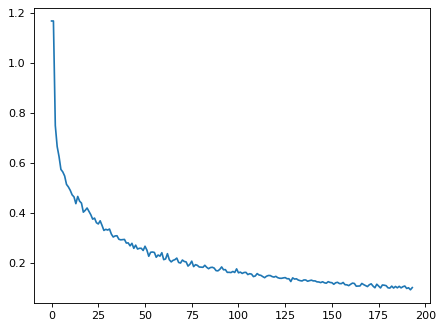

In [115]:
#parameters['reload']=False

if not parameters['reload']:
    tr = time.time()
    model.train(True)
    for epoch in tqdm(range(1,number_of_epochs)):
        for i, index in enumerate(np.random.permutation(len(train_data))):
            count += 1
            data = train_data[index]

            ##gradient updates for each data entry
            model.zero_grad()

            sentence_in = data['words']
            sentence_in = Variable(torch.LongTensor(sentence_in))
            tags = data['tags']
            chars2 = data['chars']
            
            if parameters['char_mode'] == 'LSTM':
                chars2_sorted = sorted(chars2, key=lambda p: len(p), reverse=True)
                d = {}
                for i, ci in enumerate(chars2):
                    for j, cj in enumerate(chars2_sorted):
                        if ci == cj and not j in d and not i in d.values():
                            d[j] = i
                            continue
                chars2_length = [len(c) for c in chars2_sorted]
                char_maxl = max(chars2_length)
                chars2_mask = np.zeros((len(chars2_sorted), char_maxl), dtype='int')
                for i, c in enumerate(chars2_sorted):
                    chars2_mask[i, :chars2_length[i]] = c
                chars2_mask = Variable(torch.LongTensor(chars2_mask))
            
            if parameters['char_mode'] == 'CNN':

                d = {}

                ## Padding the each word to max word size of that sentence
                chars2_length = [len(c) for c in chars2]
                char_maxl = max(chars2_length)
                chars2_mask = np.zeros((len(chars2_length), char_maxl), dtype='int')
                for i, c in enumerate(chars2):
                    chars2_mask[i, :chars2_length[i]] = c
                chars2_mask = Variable(torch.LongTensor(chars2_mask))


            targets = torch.LongTensor(tags)

            #we calculate the negative log-likelihood for the predicted tags using the predefined function
            if use_gpu:
                neg_log_likelihood = model.neg_log_likelihood(sentence_in.cuda(), targets.cuda(), chars2_mask.cuda(), chars2_length, d)
            else:
                neg_log_likelihood = model.neg_log_likelihood(sentence_in, targets, chars2_mask, chars2_length, d)
            loss += neg_log_likelihood.item() / len(data['words'])
            neg_log_likelihood.backward()

            #we use gradient clipping to avoid exploding gradients
            torch.nn.utils.clip_grad_norm(model.parameters(), gradient_clip)
            optimizer.step()

            #Storing loss
            if count % plot_every == 0:
                loss /= plot_every
                print(count, ': ', loss)
                if losses == []:
                    losses.append(loss)
                losses.append(loss)
                loss = 0.0

            #Evaluating on Train, Test, Dev Sets
            if count % (eval_every) == 0 and count > (eval_every * 20) or \
                    count % (eval_every*4) == 0 and count < (eval_every * 20):
                model.train(False)
                best_train_F, new_train_F, _ = evaluating(model, train_data, best_train_F,"Train")
                best_dev_F, new_dev_F, save = evaluating(model, dev_data, best_dev_F,"Dev")
                if save:
                    print("Saving Model to ", model_name)
                    torch.save(model.state_dict(), model_name)
#                 best_test_F, new_test_F, _ = evaluating(model, test_data, best_test_F,"Test")

                all_F.append([new_train_F, new_dev_F]) # new_test_F
                model.train(True)

            #Performing decay on the learning rate
            if count % len(train_data) == 0:
                adjust_learning_rate(optimizer, lr=learning_rate/(1+decay_rate*count/len(train_data)))

    print(time.time() - tr)
    plt.plot(losses)
    plt.show()

if not parameters['reload']:
    #reload the best model saved from training
    model.load_state_dict(torch.load(model_name))

In [118]:
model_testing_sentences = ['Jay is from India','Donald is the president of USA']

#parameters
lower=parameters['lower']

#preprocessing
final_test_data = []
for sentence in model_testing_sentences:
    s=sentence.split()
    str_words = [w for w in s]
    words = [word_to_id[lower_case(w,lower) if lower_case(w,lower) in word_to_id else '<UNK>'] for w in str_words]
    
    # Skip characters that are not in the training set
    chars = [[char_to_id[c] for c in w if c in char_to_id] for w in str_words]
    
    final_test_data.append({
        'str_words': str_words,
        'words': words,
        'chars': chars,
    })

#prediction
predictions = []
print("Prediction:")
print("word : tag")
for data in final_test_data:
    words = data['str_words']
    chars2 = data['chars']

    d = {} 
    
    # Padding the each word to max word size of that sentence
    chars2_length = [len(c) for c in chars2]
    char_maxl = max(chars2_length)
    chars2_mask = np.zeros((len(chars2_length), char_maxl), dtype='int')
    for i, c in enumerate(chars2):
        chars2_mask[i, :chars2_length[i]] = c
    chars2_mask = Variable(torch.LongTensor(chars2_mask))

    dwords = Variable(torch.LongTensor(data['words']))

    # We are getting the predicted output from our model
    if use_gpu:
        val,predicted_id = model(dwords.cuda(), chars2_mask.cuda(), chars2_length, d)
    else:
        val,predicted_id = model(dwords, chars2_mask, chars2_length, d)

    pred_chunks = get_chunks(predicted_id,tag_to_id)
    temp_list_tags=['NA']*len(words)
    for p in pred_chunks:
        temp_list_tags[p[1]]=p[0]
        
    for word,tag in zip(words,temp_list_tags):
        print(word,':',tag)
    print('\n')

Prediction:
word : tag
Jay : NA
is : NA
from : NA
India : NA


Donald : NA
is : NA
the : NA
president : NA
of : NA
USA : NA


